# Importing all needed libraries

In [65]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn import metrics

## Reading data files

In [2]:
bank_data = pd.read_json("bank.json")

In [3]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Cleaning data
As the 'pdays' variable states for the number of days that passed by after the client was last contacted from a previous campaign I'm replacing the -1 for 0.

In [4]:
bank_data.loc[bank_data['pdays'] == -1, 'pdays'] = 0

## Checking for missing values

In [5]:
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## Dropping unwanted columns
As I don't need them, I'm dropping the columns 'contact', 'day', 'month' and 'poutcome'.

In [6]:
bank_data = bank_data.drop(['contact', 'day', 'month', 'poutcome'], axis = 1)

In [7]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y
0,30,unemployed,married,primary,no,1787,no,no,79,1,0,0,no
1,33,services,married,secondary,no,4789,yes,yes,220,1,339,4,no
2,35,management,single,tertiary,no,1350,yes,no,185,1,330,1,no
3,30,management,married,tertiary,no,1476,yes,yes,199,4,0,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,226,1,0,0,no


## EDA

### Pair plotting to check the distributions of the values.

<Figure size 720x576 with 0 Axes>

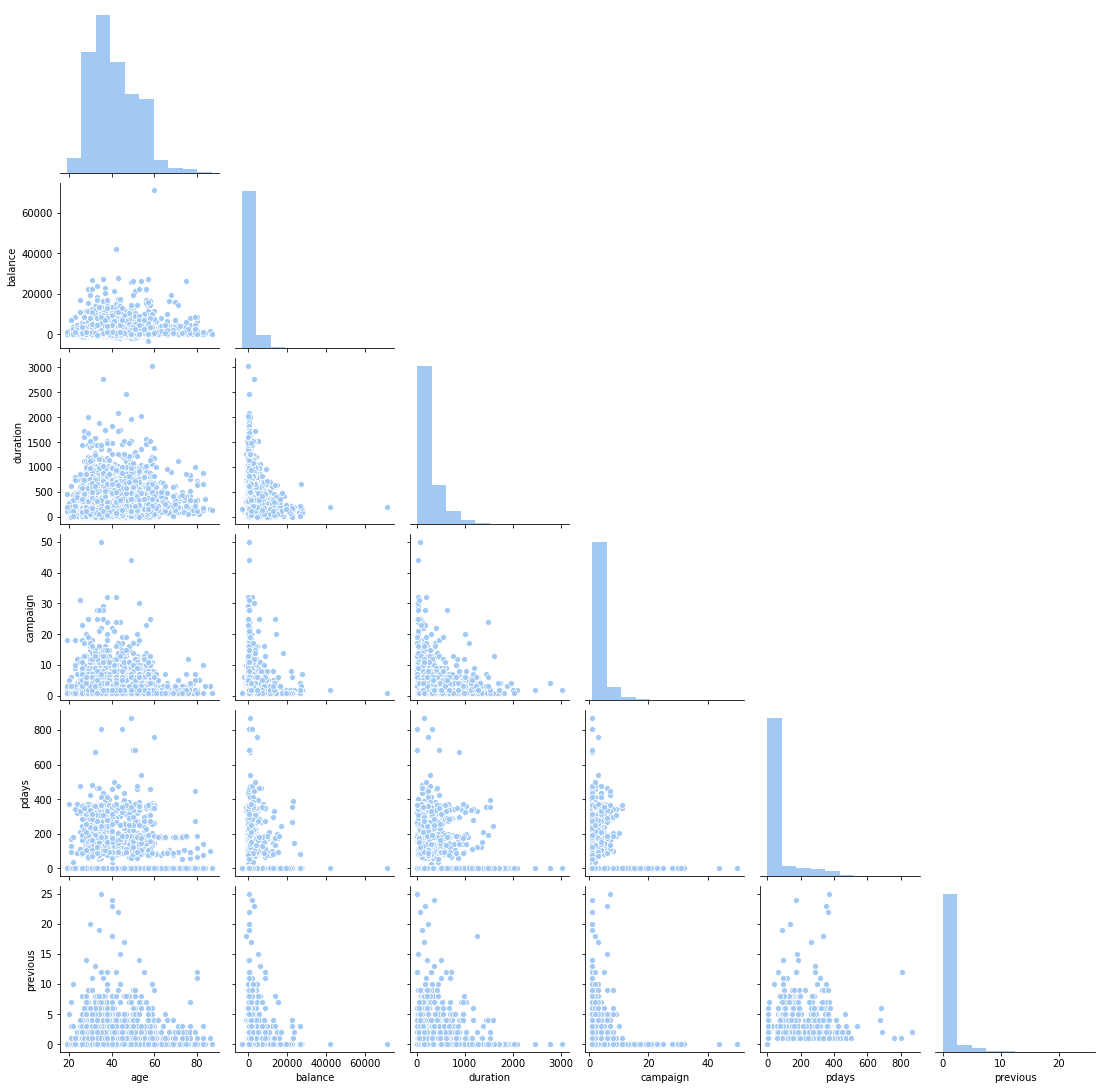

In [8]:
sns.set_palette("pastel")
fig = plt.figure(figsize=(10,8))
g = sns.pairplot(bank_data,corner=True)

From the graph above we can see how the distribution of almost all the variables is very skewed to the right. We can also see how there's visually high entropy, which makes it a good dataset for K-Means.

### Describing the variables

In [9]:
bank_data.describe()

,age,balance,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,263.961292,2.793630,40.586154,0.542579
std,10.576211,3009.638142,259.856633,3.109807,99.787552,1.693562
min,19.000000,-3313.000000,4.000000,1.000000,0.000000,0.000000
25%,33.000000,69.000000,104.000000,1.000000,0.000000,0.000000
50%,39.000000,444.000000,185.000000,2.000000,0.000000,0.000000
75%,49.000000,1480.000000,329.000000,3.000000,0.000000,0.000000
max,87.000000,71188.000000,3025.000000,50.000000,871.000000,25.000000


We can see how the 'balance' variable has the highest standard deviation and from the previous graph we see is the most scattered. However I will keep it like that and decided not to normalize it since I want to be able to discriminate between different levels of account balances.

## Variables colinearity analysis

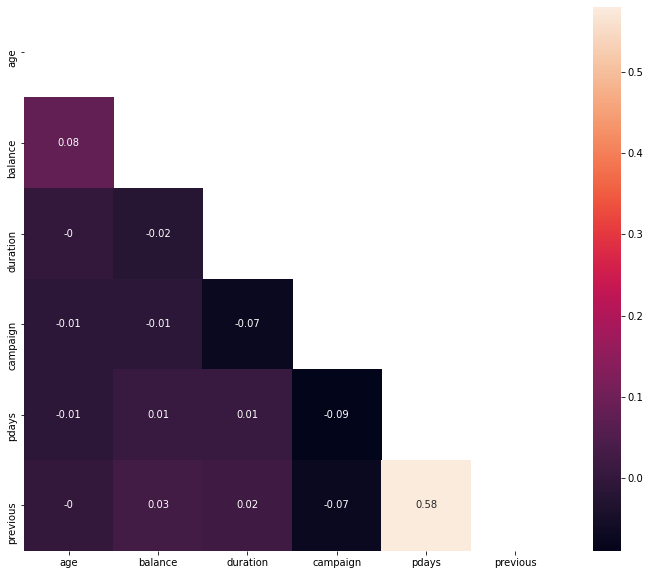

In [10]:
corr = round(bank_data.corr(),2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True)


There's no particular colinearity between variables.

In [11]:
# Target Variable distribution
x_terms = bank_data['y'].value_counts()
x_terms

no     4000
yes     521
Name: y, dtype: int64

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 720x576 with 0 Axes>

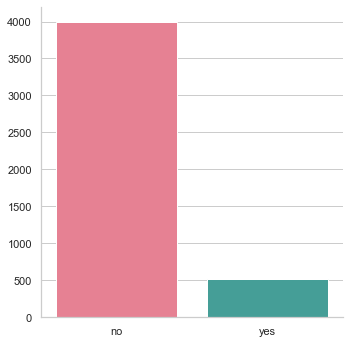

In [12]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))

sns.catplot(x=bank_data['y'], kind="count", palette="husl", data=bank_data);


## Campaign Marketing Customer Segmentation

Using the unsupervised machine learning algorithm K-Means I will segmentate customers based on the RFM (Recency, Frequency, Monetary Value) framework.

- Recency: Will be pointed at the variable 'pdays' which states for the number of days since we last impacted the customer.

- Frequency: Will be pointed at the variable 'campaign' which states for the number of campaigns the client received.

- Monetary Value: We will point it at the variable 'balance' which states for the account balance of the client. 

This classification will allow us to determine different marketing strategies to apply to the customers in the future.


At the end we will generate an Overall Score to classify our customers into three different groups:
- 0 = Low Value
- 1 = Medium Value
- 2 = High Value

## K-Means clustering for recency

### Descriptive statistics analysis to understand distributions

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Proportion')

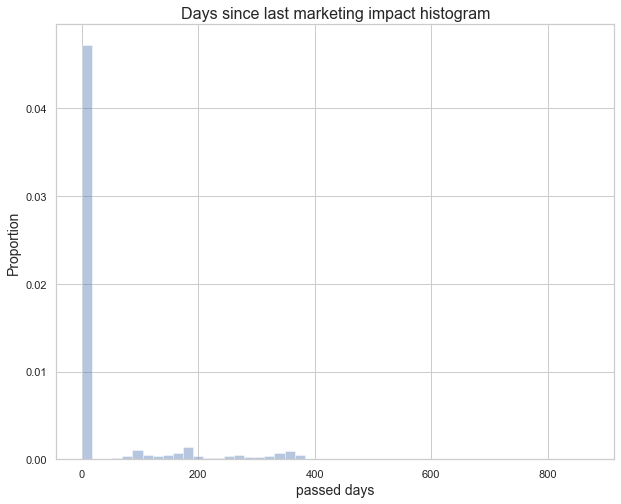

In [13]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
ax = sns.distplot(bank_data["pdays"])

ax.axes.set_title("Days since last marketing impact histogram",fontsize=16)
ax.set_xlabel("passed days",fontsize=14)
ax.set_ylabel("Proportion",fontsize=14)

In [14]:
bank_data["pdays"].describe()

count    4521.000000
mean       40.586154
std        99.787552
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       871.000000
Name: pdays, dtype: float64

As we can see the data is highly skewed to the right, as more than 75% of the data is close to 0. 

However we can see how the mean is 40.5 days since the last client-campaign interaction which gives us a little bit more of insight for later.

### Elbow graph (inertia) analysis to determine the number of clusters

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

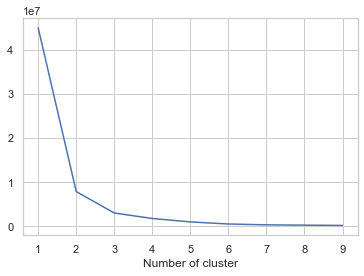

In [15]:
from sklearn.cluster import KMeans

sse={}
client_recency = bank_data[['pdays']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(client_recency)
    client_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()



It seems like the optimal number of clusters is 3. Therefore we will classify them accordingly:

In [16]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(client_recency[['pdays']])
bank_data['RecencyCluster'] = kmeans.predict(client_recency[['pdays']])

In [17]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,RecencyCluster
0,30,unemployed,married,primary,no,1787,no,no,79,1,0,0,no,0
1,33,services,married,secondary,no,4789,yes,yes,220,1,339,4,no,1
2,35,management,single,tertiary,no,1350,yes,no,185,1,330,1,no,1
3,30,management,married,tertiary,no,1476,yes,yes,199,4,0,0,no,0
4,59,blue-collar,married,secondary,no,0,yes,no,226,1,0,0,no,0


In [18]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [19]:
recency_data = order_cluster('RecencyCluster', 'pdays',bank_data,True)

In [20]:
recency_data.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,RecencyCluster
0,30,unemployed,married,primary,no,1787,no,no,79,1,0,0,no,0
1,30,management,married,tertiary,no,1476,yes,yes,199,4,0,0,no,0
2,59,blue-collar,married,secondary,no,0,yes,no,226,1,0,0,no,0
3,39,technician,married,secondary,no,147,yes,no,151,2,0,0,no,0
4,41,entrepreneur,married,tertiary,no,221,yes,no,57,2,0,0,no,0


In [21]:
# Grouping by clusters and means of the rest of variables
recency_data.groupby("RecencyCluster").mean()

,age,balance,duration,campaign,pdays,previous
RecencyCluster,,,,,,
0,41.099893,1372.772630,262.160686,2.954472,0.246652,0.027049
1,43.039080,2018.889655,277.600000,1.933333,146.609195,3.085057
2,39.433140,1214.947674,265.636628,2.165698,328.386628,2.845930
3,47.000000,1218.000000,290.750000,1.500000,728.625000,3.875000


### Visualizaing K-means Recency clusters

Text(0, 0.5, 'Days passed')

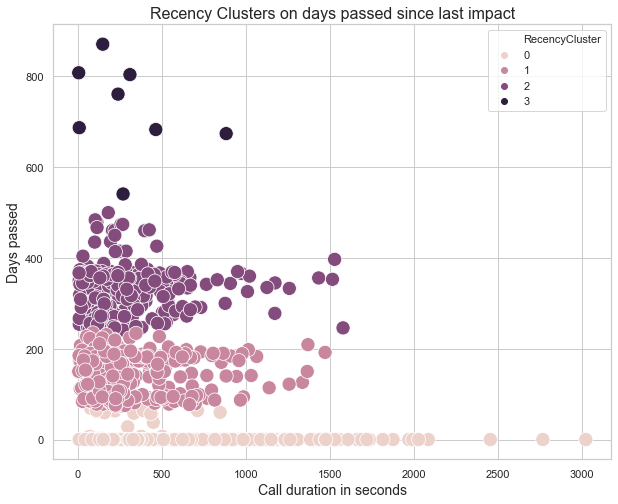

In [22]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(10,8))
a = sns.scatterplot(recency_data["duration"], recency_data["pdays"],hue= recency_data["RecencyCluster"], s=200)

a.axes.set_title("Recency Clusters on days passed since last impact",fontsize=16)
a.set_xlabel("Call duration in seconds",fontsize=14)
a.set_ylabel("Days passed",fontsize=14)

As we can see from the graph above we have successfully segmented the clients by their Recency (pdays). We can see how the discrimination works by the number of days that have passed since the last campaing impact. 

I have added a 4th cluster since it seemed that I had very few users that had not received an impact in more than 600 days (almost 2 years). This made it interesting for me to give them their own cluster as it would help the marketing approach we decide to do later.

I've also added the 'duration' variable to the graph, and we can see that the "newly impacted" clients have had more call duration in seconds. This could explain that our sales team is becoming more efficient or also that there was a change in the sales approach. It could be related to a new product that makes newly approached clients express more interest.

## K-Means clustering for frequency

## Descriptive statistics to understand frenquency variable

Text(0, 0.5, 'Proportion')

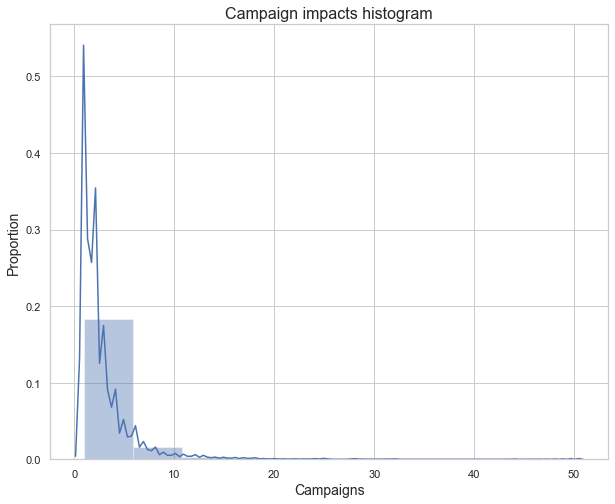

In [23]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
ax = sns.distplot(bank_data["campaign"], bins=10)

ax.axes.set_title("Campaign impacts histogram",fontsize=16)
ax.set_xlabel("Campaigns",fontsize=14)
ax.set_ylabel("Proportion",fontsize=14)

In [24]:
bank_data["campaign"].describe()

count    4521.000000
mean        2.793630
std         3.109807
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        50.000000
Name: campaign, dtype: float64

The data is skewed to the right. The average number of campaigns a client gets is 2.79. And we could say 68% of the data is around 2-3 received campaigns. However it seems we have outliers, as we can see in the graph and the max value being 50.

### Elbow graph (inertia) analysis to determine the number of clusters

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

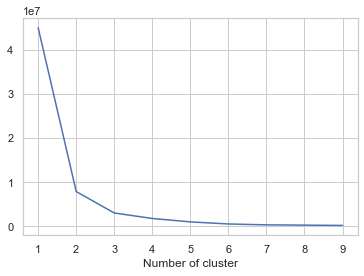

In [25]:
sse={}
client_frequency = bank_data[['campaign']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(client_recency)
    client_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [26]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(client_frequency[['campaign']])
bank_data['FrequencyCluster'] = kmeans.predict(client_frequency[['campaign']])

In [27]:
frequency_data = order_cluster('RecencyCluster', 'pdays',bank_data,True)
frequency_data.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,FrequencyCluster,RecencyCluster
0,30,unemployed,married,primary,no,1787,no,no,79,1,0,0,no,0,0
1,30,management,married,tertiary,no,1476,yes,yes,199,4,0,0,no,3,0
2,59,blue-collar,married,secondary,no,0,yes,no,226,1,0,0,no,0,0
3,39,technician,married,secondary,no,147,yes,no,151,2,0,0,no,0,0
4,41,entrepreneur,married,tertiary,no,221,yes,no,57,2,0,0,no,0,0


### Visualizing K-Means clusters for client frequency

Text(0, 0.5, 'Campaign Impacts')

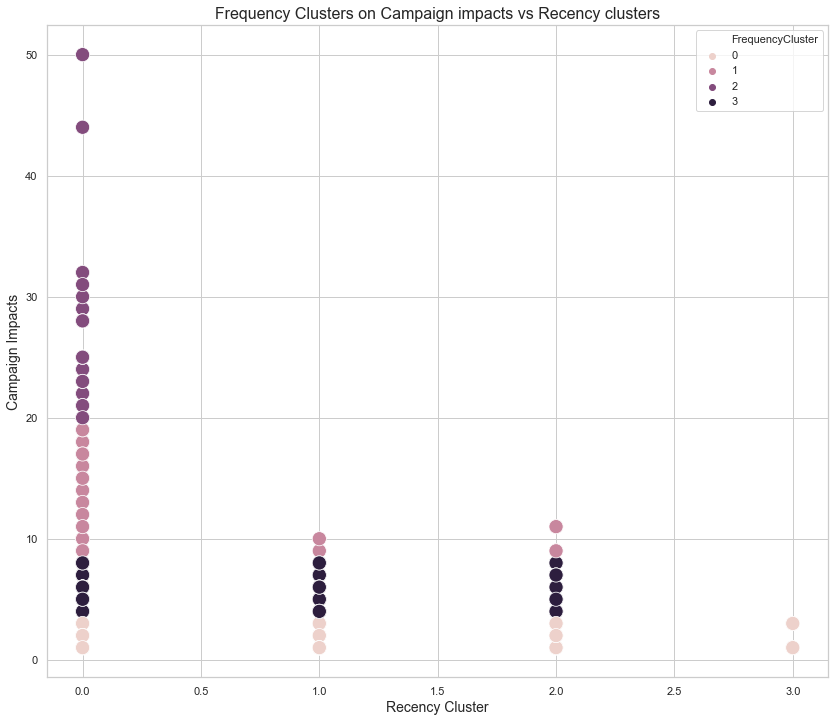

In [28]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(14,12))
title = 'Frenquency Clusters'
b = sns.scatterplot(frequency_data["RecencyCluster"], frequency_data["campaign"],hue= frequency_data["FrequencyCluster"], s=200)


b.axes.set_title("Frequency Clusters on Campaign impacts vs Recency clusters",fontsize=16)
b.set_xlabel("Recency Cluster",fontsize=14)
b.set_ylabel("Campaign Impacts",fontsize=14)

The figure above shows the different clusters based on impacts received by the client. We can see how the K-Means algorithm worked properly based on the values of the campaign impacts. 

I wanted to show also the 'Recency' clusters to state that there is something happening with newly impacted clients. We see all the clients that receive more than 20 campaign impacts belong to the recency cluster 0. This could mean that our sales efforts are maybe being to agressive.

## K-Mean clustering for Monetary Value

### Descriptive statistics to understand the variable

Text(0, 0.5, 'Proportion')

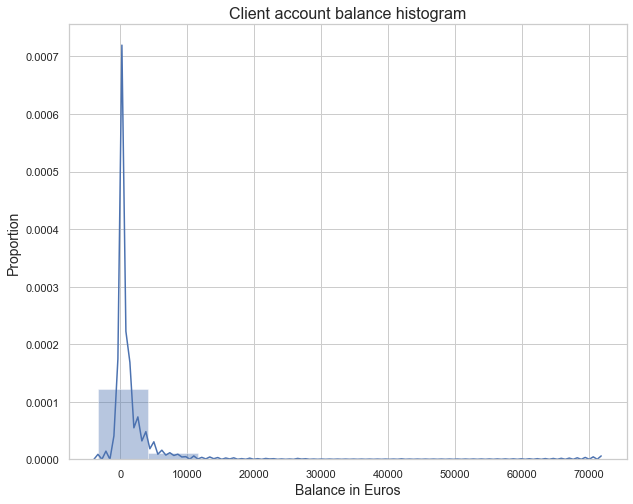

In [29]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
ax = sns.distplot(bank_data["balance"], bins=10)

ax.axes.set_title("Client account balance histogram",fontsize=16)
ax.set_xlabel("Balance in Euros",fontsize=14)
ax.set_ylabel("Proportion",fontsize=14)

In [30]:
bank_data["balance"].describe()

count     4521.000000
mean      1422.657819
std       3009.638142
min      -3313.000000
25%         69.000000
50%        444.000000
75%       1480.000000
max      71188.000000
Name: balance, dtype: float64

From the data above we see that the data is more spread distributed, that's why the standard deviation is the highest from the three variables observed. 

The data is still very skewed to the right. We see how almost 75% of the data is around the mean and we have outliers by looking the min and max.

However I will keep those outliers since they can provide insight on the monetary value of these clients and their associated risk. What i would do is normalize the data in the next step.

### Elbow graph (inertia) analysis to determine the number of clusters

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

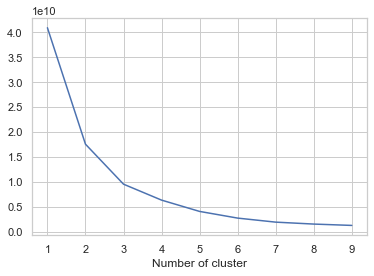

In [31]:
sse={}
client_value = bank_data[['balance']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(client_value)
    client_value["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

We see here how the number of optimal clusters might be bigger as the data is more spread. I've decided to try 6 clusters as I want to capture the differences between the different data points properly.

In [32]:
#build 6 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=6)
kmeans.fit(client_value[['balance']])
bank_data['ValueCluster'] = kmeans.predict(client_value[['balance']])

In [33]:
value_data = order_cluster('ValueCluster', 'balance',bank_data,True)
value_data.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,RecencyCluster,FrequencyCluster,ValueCluster
0,30,unemployed,married,primary,no,1787,no,no,79,1,0,0,no,0,0,1
1,30,management,married,tertiary,no,1476,yes,yes,199,4,0,0,no,0,3,1
2,56,technician,married,secondary,no,4073,no,no,239,5,0,0,no,0,3,1
3,37,admin.,single,tertiary,no,2317,yes,no,114,1,152,2,no,2,0,1
4,68,retired,divorced,secondary,no,4189,no,no,897,2,0,0,yes,0,0,1


### Visualizing K-mean clustering for Client Value

Text(0, 0.5, 'Account Balance')

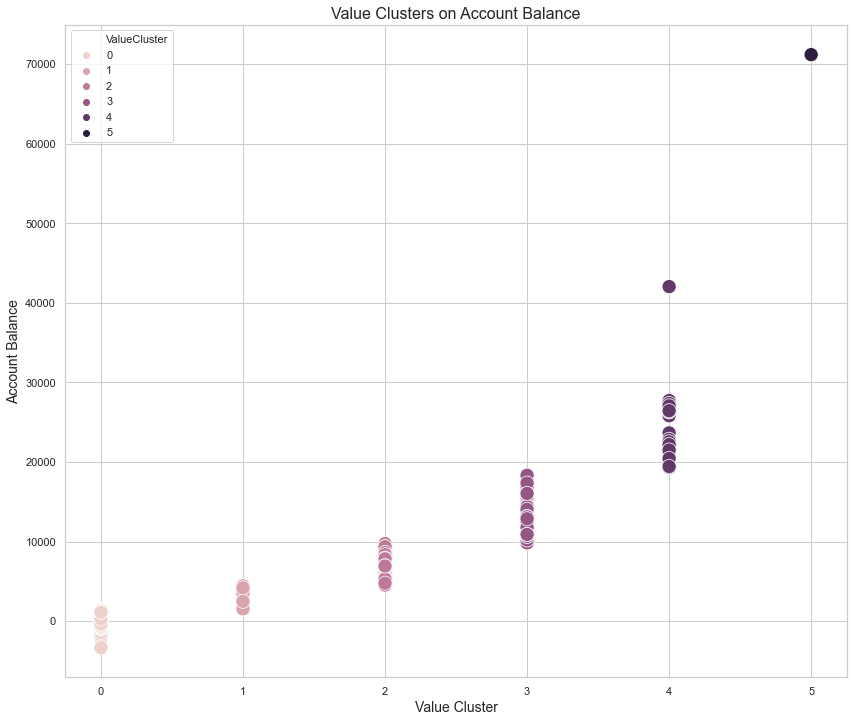

In [34]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(14,12))
title = 'Value Clusters'
b = sns.scatterplot(value_data["ValueCluster"], value_data["balance"],hue= value_data["ValueCluster"], s=200, legend='full')


b.axes.set_title("Value Clusters on Account Balance",fontsize=16)
b.set_xlabel("Value Cluster",fontsize=14)
b.set_ylabel("Account Balance",fontsize=14)

I'm not happy with the clustering as it's putting the customers with account balance in 0 in the same clusters as those with a negative account balance.

Therefore I'm trying to optimize the clustering with K=9.

In [35]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(client_value[['balance']])
bank_data['ValueCluster'] = kmeans.predict(client_value[['balance']])

In [36]:
value_data = order_cluster('ValueCluster', 'balance',bank_data,True)
value_data.head()

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y,RecencyCluster,FrequencyCluster,ValueCluster
0,30,unemployed,married,primary,no,1787,no,no,79,1,0,0,no,0,0,1
1,35,management,single,tertiary,no,1350,yes,no,185,1,330,1,no,1,0,1
2,30,management,married,tertiary,no,1476,yes,yes,199,4,0,0,no,0,3,1
3,35,management,single,tertiary,no,747,no,no,141,2,176,3,no,2,0,1
4,36,technician,married,tertiary,no,1109,no,no,328,2,0,0,no,0,0,1


### Visualizing with K=9

Text(0, 0.5, 'Account Balance')

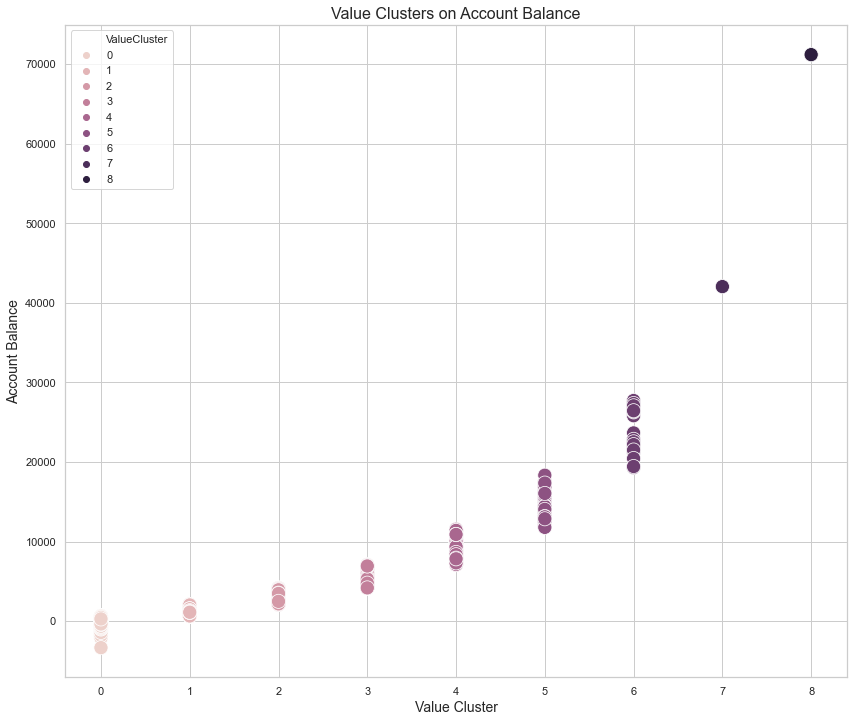

In [37]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(14,12))
title = 'Value Clusters'
b = sns.scatterplot(value_data["ValueCluster"], value_data["balance"],hue= value_data["ValueCluster"], s=200, 
                    legend='full')


b.axes.set_title("Value Clusters on Account Balance",fontsize=16)
b.set_xlabel("Value Cluster",fontsize=14)
b.set_ylabel("Account Balance",fontsize=14)

Clustering with k=9 seems more efficient to discriminate different types of clients by their monetary value. Therefore I'm updating the clustering in the original dataset. 

## Predictions
At last I will use the Logistic Regression algorithm to predict if the clients decided to subscribe term deposits (binary prediction) and give answers to:
1. Is Client-Bank communication relationship relevant when the customer decides to subscribe a term deposit? 
2. Is economic and social status relevant for clients to subscribe term deposits?

### Extending the data with the getdummies function

In [38]:
pred_data = pd.get_dummies(bank_data, drop_first=True)

In [39]:
pred_data.head()

,age,balance,duration,campaign,pdays,previous,RecencyCluster,FrequencyCluster,ValueCluster,job_blue-collar,...,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,y_yes
0,30,1787,79,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,33,4789,220,1,339,4,1,0,3,0,...,0,1,0,1,0,0,0,1,1,0
2,35,1350,185,1,330,1,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
3,30,1476,199,4,0,0,0,3,0,0,...,0,1,0,0,1,0,0,1,1,0
4,59,0,226,1,0,0,0,0,4,1,...,0,1,0,1,0,0,0,1,0,0


In [40]:
# This is just to get the column names
pred_data.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'RecencyCluster', 'FrequencyCluster', 'ValueCluster', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_yes', 'housing_yes', 'loan_yes', 'y_yes'],
      dtype='object')

### Is Client-Bank relation relevant when the client decides to subscribe for a term deposit?

I will begin selecting the correct data and splitting for train and test.

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
# Selecting on the X vector only the data related to Client-Bank relation
y = pred_data[["y_yes"]]
X = pred_data.drop(['y_yes', 'age', 'balance', 'RecencyCluster', 'FrequencyCluster', 'ValueCluster', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Initializing model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [44]:
#Fitting train data
model.fit(X_train, y_train)

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[[790  80]
 [ 17  18]]
_________________


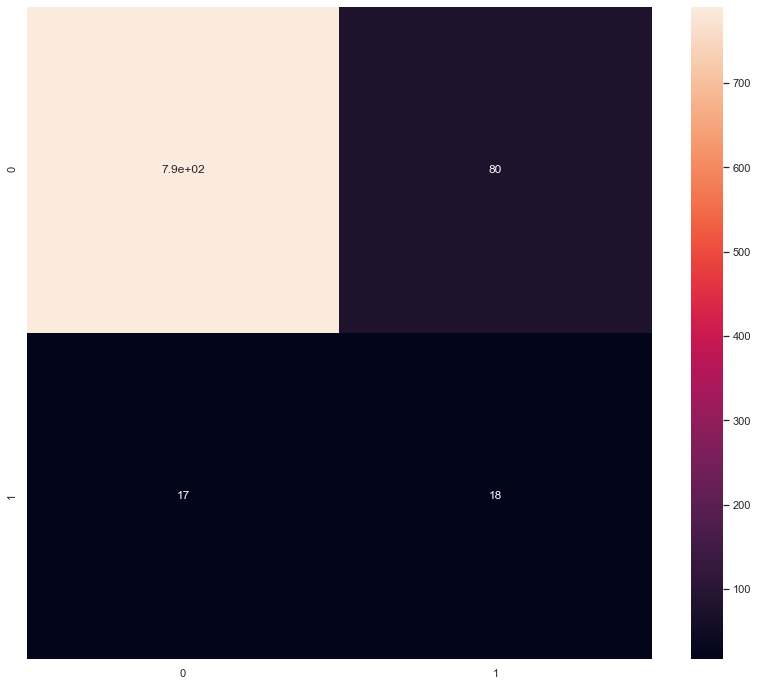

In [45]:
# Prediction
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score as acs
y_pred = model.predict(X_test)

# Confusion matrix heatmap
fig = plt.figure(figsize=(14,12))
title = 'Confusion Matrix'
sns.heatmap(cm(y_pred, y_test), annot=True)
print(cm(y_pred, y_test))
print('_________________')


In [46]:
# Model accuracy and false positives, false negatives proportion
print(f"The model scored a nice {acs(y_pred, y_test)} in accuracy, which is pretty good.")
print(f"However I see the false positives in the confusion matrix to be rather high at {(80/(790+80))}%")
print(f"The false negatives in the confusion matrix are pretty high at a proportion of {(17/(17+18))}%")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

The model scored a nice 0.8928176795580111 in accuracy, which is pretty good.
However I see the false positives in the confusion matrix to be rather high at 0.09195402298850575%
The false negatives in the confusion matrix are pretty high at a proportion of 0.4857142857142857%
Accuracy: 0.8928176795580111
Precision: 0.5142857142857142
Recall: 0.1836734693877551
[[790  17]
 [ 80  18]]


In [47]:
# Seeing the distribution of subscribed term deposits in our data
pred_data["y_yes"].value_counts()

0    4000
1     521
Name: y_yes, dtype: int64

#### Conclusion 1
Client-Bank relationship could be a good explanator-predictor of how likely a customer is willing to subscribe a term deposit. The model scored an Accuracy of 0.89, which is pretty good and a Recall of 0.18 (which makes sense when we evaluate it against the 521/4000 of true positives ratio from above).

It's important to say that the Client-Bank relationship data points are non categorical, which make the perfect data to use in a Logistic Regression algorithm and make it an accurate predictor.

### Is economic and social status relevant for clients to subscribe term deposits?

In [48]:
# Selecting on the X vector only the data related to economic and social status of the customer
y = pred_data[["y_yes"]]
X = pred_data.drop(['y_yes', 'duration', 'campaign', 'pdays', 'previous', 'RecencyCluster',
                    'FrequencyCluster', 'ValueCluster', 'default_yes', 'housing_yes', 'loan_yes'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [49]:
# Initializing model
model_econsoc = LogisticRegression()

In [50]:
#Fitting train data
model_econsoc.fit(X_train, y_train)

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[[807  98]
 [  0   0]]
_________________


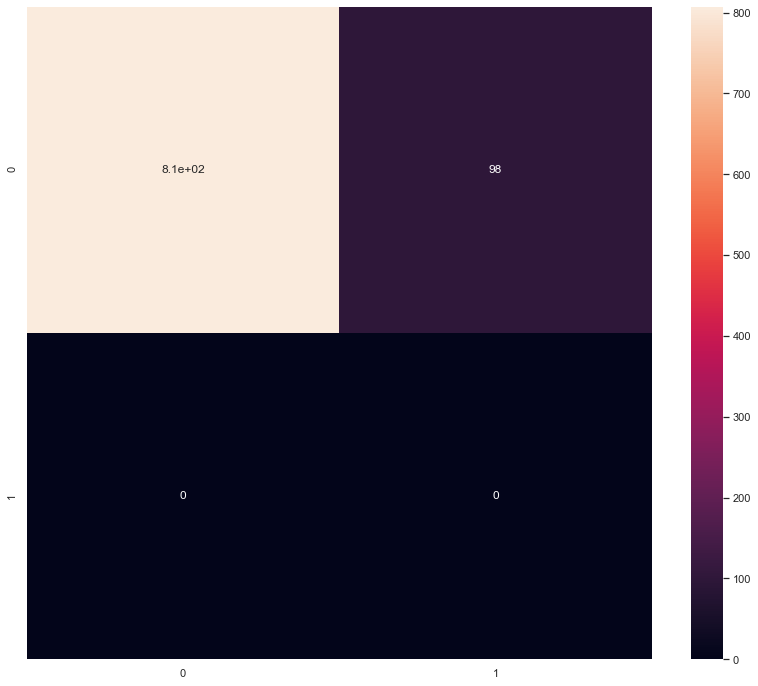

In [51]:

# Prediction
y_pred = model_econsoc.predict(X_test)

# Confusion matrix heatmap
fig = plt.figure(figsize=(14,12))
title = 'Confusion Matrix'
sns.heatmap(cm(y_pred, y_test), annot=True)
print(cm(y_pred, y_test))
print('_________________')

In [52]:
# Evaluating the model
print(f"The model scored a nice {acs(y_pred, y_test)} in accuracy, which is pretty good.")
print(f"However I see the false positives in the confusion matrix to be rather high at {(98/(807+98))}%")
print(f"The model couldn't predict any true positive")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

The model scored a nice 0.8917127071823204 in accuracy, which is pretty good.
However I see the false positives in the confusion matrix to be rather high at 0.10828729281767956%
The model couldn't predict any true positive
Accuracy: 0.8917127071823204
Precision: 0.0
Recall: 0.0


/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


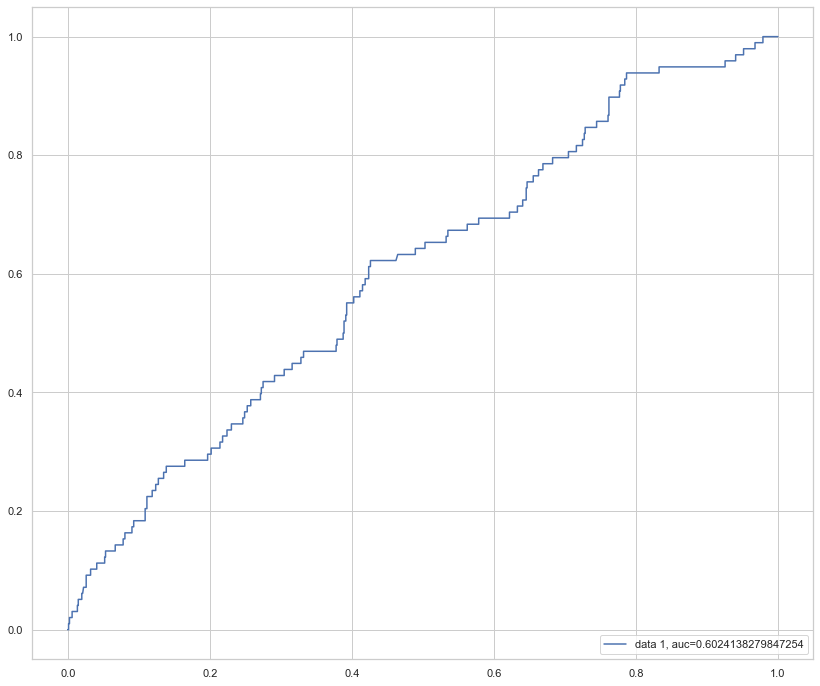

In [53]:
y_pred_proba = model_econsoc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

fig = plt.figure(figsize=(14,12))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Conclusion 2

The are under the curve could be interpreted as how good a model is at discriminating between classes. With an area under the curve of 0.5 The model would not be a good predictor of class as it wouldn't have separation capacity. 

With an area under the curve of 0 or near to 0 it would mean the predictor is completely backwards. It would predict True Positives as False Positives and viceversa. 

From the graph above we see how the Area Under The Curve is 0.60, very close to being an irrelevant predictor as it cannot discriminate well between classes. In fact, it doesn't predict any True or False positives.

With our current data we can't conclude if the economic and social status influences the clients subscribing a long term deposit. Our model is not capable of predicting it, even if it has a high accuracy.

Logistic Regressions are not good with categorical value. I would run a Decission Tree algorithm to try and understand how does economic and social status impacts the clients to subscribe for a term deposit.

## Full data Logistic Regression

In [54]:
# Selecting on the X vector only the data related to economic and social status of the customer
y = pred_data[["y_yes"]]
X = pred_data.drop(['y_yes', 'RecencyCluster',
                    'FrequencyCluster', 'ValueCluster'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[790  79]
 [ 17  19]]
_________________


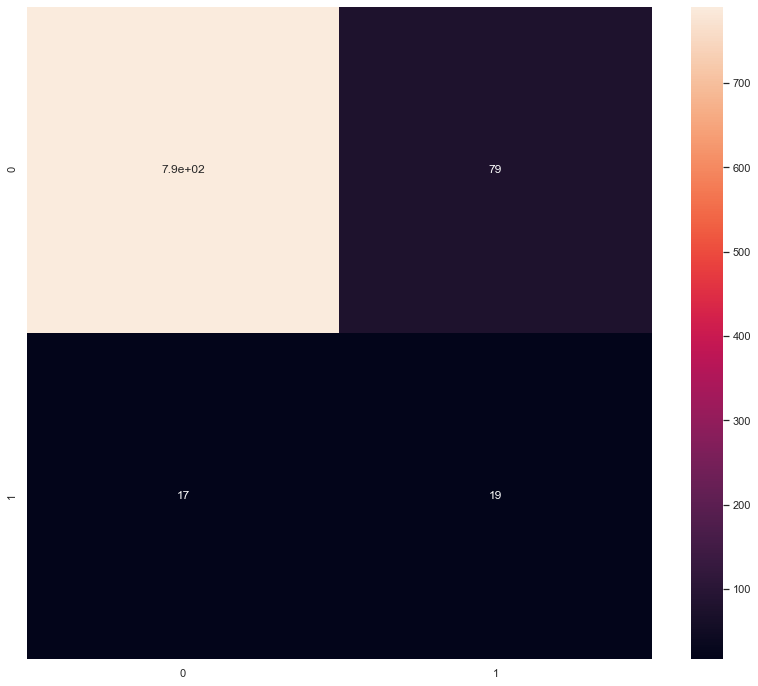

In [55]:
# Initializing model
model_full = LogisticRegression()

#Fitting train data
model_full.fit(X_train, y_train)

# Prediction
y_pred = model_full.predict(X_test)

# Confusion matrix heatmap
fig = plt.figure(figsize=(14,12))

sns.heatmap(cm(y_pred, y_test), annot=True)
print(cm(y_pred, y_test))
print('_________________')

In [56]:
# Evaluating the model
print(f"The model scored a nice {acs(y_pred, y_test)} in accuracy, which is pretty good.")
print(f"However I see the false positives in the confusion matrix to be rather high at {(79/(790+79))}%")
print(f"Teh false positives are at {(17/(17+19))}%")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

The model scored a nice 0.8939226519337017 in accuracy, which is pretty good.
However I see the false positives in the confusion matrix to be rather high at 0.09090909090909091%
Teh false positives are at 0.4722222222222222%
Accuracy: 0.8939226519337017
Precision: 0.5277777777777778
Recall: 0.19387755102040816
[[790  17]
 [ 79  19]]


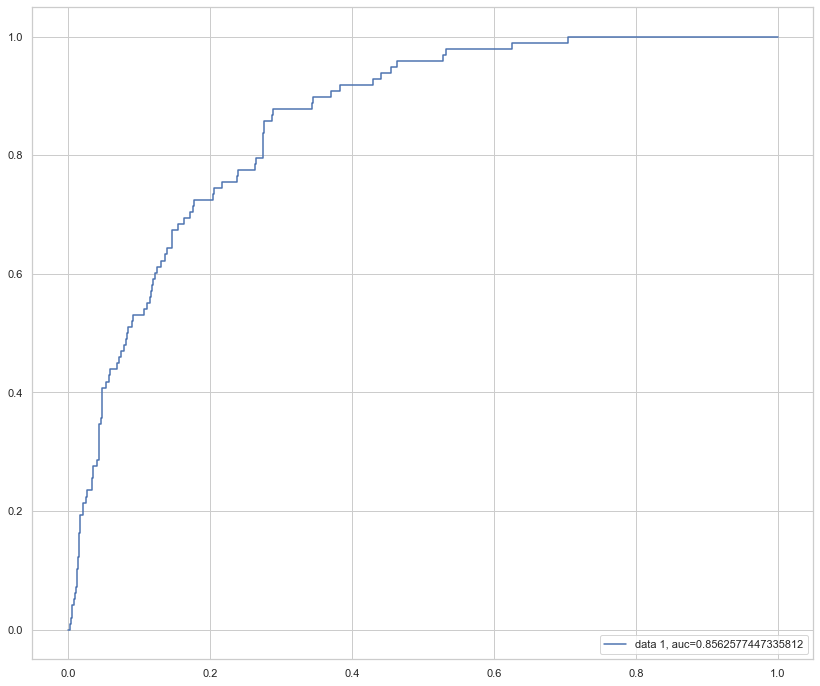

In [57]:
# ROC Curve evaluation
y_pred_proba = model_full.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

fig = plt.figure(figsize=(14,12))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

From the graph above we see the full data model is a pretty good predictor with an area under the curve of 0.85, being the perfect predictor 1.


### Conclusion 3
As we see from both algorithms from above the categorical data for explaining the economical and social status of a client is virtually non relevant when building a good prediction algorithm using LogisticRegression.



## Decission Tree classificator for SocioEconomic status

In [60]:
# Fitting a decission tree predictor classifier with the SocioEconomic variables
from sklearn import tree
y = pred_data[["y_yes"]]
X = pred_data.drop(['y_yes', 'duration', 'campaign', 'pdays', 'previous', 'RecencyCluster',
                    'FrequencyCluster', 'ValueCluster', 'default_yes', 'housing_yes', 'loan_yes'], axis =1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42) # 95% training and 5% test
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [61]:
# Prediction
y_pred = clf.predict(X_test)

In [62]:
# Accuracy of the model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7878453038674034


### Optimization of the Decission Tree

In [71]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8895027624309392


In [72]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('EconSoc.png')
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'